### Multi-Task Learning Pipeline

Install the Jupyter notebook kernel with `python3 -m ipykernel install --user --name arise --display-name "ARISE"`

In [1]:
from tsfresh import extract_features, extract_relevant_features
import sys, os, math, random, glob, torch
from pprint import pprint
import numpy as np
import pandas as pd
from sklearn import *
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
from utils import *
from tsfresh.feature_extraction.feature_calculators import set_property
from tsfresh.feature_extraction import feature_calculators

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

DATA_DIR = get_full_path("data_28") + "/"
FIGURE_DIR = get_full_path("MTL", "Figures") + "/"

CUDA_INDEX = 0 # 0..2 for Mitra, -1 to disable (force CPU)
# CUDA_INDEX = -1

# Device Configuration
if torch.cuda.is_available() and CUDA_INDEX >= 0:
    device = torch.device(f'cuda:{CUDA_INDEX}') # MITRA has 3 CUDA GPUs available; use the third.
    torch.cuda.set_device(CUDA_INDEX)
else:
    print("Warning: Defaulting to CPU.")
    device = torch.device('cpu')

/home/jknofczy/miniconda3/envs/arise/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jknofczy/miniconda3/envs/arise/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [3]:
# If there are issues after first booting the project, verify the proper version of Snorkel is installed.
%pip install snorkel==0.9.6

  Using cached https://files.pythonhosted.org/packages/4e/6a/e33babd8b4fb34867b695b5ab6b02c9106ec9de05ed4a02b2b9417eb3ae7/snorkel-0.9.6-py3-none-any.whl
  Found existing installation: snorkel 0.9.7
    Uninstalling snorkel-0.9.7:
      Successfully uninstalled snorkel-0.9.7
Note: you may need to restart the kernel to use updated packages.


### Load in raw datasets

In [3]:
raw = get_all_datasets() # from utils.py
master = raw
# master.to_csv(ROOT_DIR + "/MTL/data/Master Dataset.csv", encoding='utf-8', header=True)

### Feature Extraction using `tsfresh`  
First, we define the custom set of features that we wish to extract.  
Then, we choose which features will be actually extracted and we perform the extraction.  

In [4]:
from tsfresh.feature_extraction.feature_calculators import set_property
from tsfresh.feature_extraction import feature_calculators

@set_property("fctype", "simple")
def count_nonzero(x):
    """ Returns the number of nonzero (non-loss) measurements in the time series x. """
    return np.count_nonzero(x)

@set_property("fctype", "simple")
def noise_threshold(x):
    """ Returns the noise threshold for a time series 
        by taking 1.5 * the RTT value at the 75th percentile. """
    x = x[x != 0] # remove all loss points from consideration
    return np.percentile(x, 75) * 1.5

@set_property("fctype", "simple")
def congestion_threshold(x):
    """ Returns the congestion threshold for a time series 
        by taking 1.2 * the RTT value at the 30th percentile. """
    x = x[x != 0] # remove all loss points from consideration
    return np.percentile(x, 30) * 1.2


# Add custom features to list of feature calculators:
# feature_calculators.__dict__["num_outages"] = num_outages
feature_calculators.__dict__["count_nonzero"] = count_nonzero
feature_calculators.__dict__["noise_thresh"] = noise_threshold
feature_calculators.__dict__["congestion_thresh"] = congestion_threshold

# https://tsfresh.readthedocs.io/en/latest/text/feature_extraction_settings.html

custom = {
    "quantile": [{"q": 0.75}], # 75% means this is the point at which it is higher value than 75% of all data points.
    "median": None,
    "mean": None,
    "standard_deviation": None,
    "noise_thresh": None,
    "congestion_thresh": None,
#     "large_standard_deviation": [{'r': 0.1}]
}

In [5]:
# disable_progress_bar = True
disable_progress_bar = False

""" ----- Select dataframe to extract features on ----- """
df = master  # CAIDA 28 datasets
# caida_features = extract_features(master, default_fc_parameters=custom, column_id="id", \
#                             column_sort="index", column_value="rtt", \
#                             disable_progressbar=disable_progress_bar).round(5)


""" Uncomment to use RIPE Atlas Data. """
## df = pd.read_csv("data/RIPE Atlas Dataset.csv") # removed to save space, 5/6/2021
# df = pd.read_csv("data/RIPE_changepoint.csv", index_col="Unnamed: 0") # use this to load pre-labeled ripe dataset
# df.rename(columns={'Unnamed: 0.1':'index'}, inplace=True)


""" Perform feature extraction with custom settings """
features = extract_features(df, default_fc_parameters=custom, column_id="id", \
                            column_sort="index", column_value="rtt", \
                            disable_progressbar=disable_progress_bar).round(5)

# features.to_csv(ROOT_DIR + "/MTL/Features.csv", encoding='utf-8', header=True)
# features.to_csv(ROOT_DIR + "/MTL/RIPE Atlas Features.csv", encoding='utf-8', header=True)

features

Feature Extraction: 100%|██████████| 28/28 [00:00<00:00, 432.14it/s]


,rtt__quantile__q_0.75,rtt__median,rtt__mean,rtt__standard_deviation,rtt__noise_threshold,rtt__congestion_threshold
0,30.12300,27.0065,33.82896,30.52835,45.18450,30.12324
1,16.65950,13.9430,19.80178,27.79079,24.98925,14.60280
2,29.49200,26.6660,32.39799,33.78114,44.23800,29.90136
3,140.34050,105.0420,91.60246,59.13177,210.51075,38.58852
4,35.74100,32.8490,38.56521,27.53349,53.61150,37.37784
5,22.09100,15.5560,24.74454,32.59514,33.13650,16.03344
6,33.69800,30.8610,36.51597,26.83374,50.54700,34.85040
7,16.75750,13.5705,20.87237,33.35229,25.13625,14.18400
8,21.61100,15.4570,23.79601,29.80547,32.41650,15.91152
9,29.30550,26.4845,32.68720,31.35319,43.95825,29.73468


### Building LFs and Synthesizing new data

In [6]:
VOTE    =  1
NORMAL  =  0
ABSTAIN = -1

def label_noise(rtt, client_index):
    noise_threshold = features['rtt__noise_threshold'][client_index]
    if rtt >= noise_threshold:
        label = VOTE
    else:
        label = NORMAL
    return label

def label_outage(rtt, client_index):
    if rtt == 0:
        label = VOTE
    else:
        label = NORMAL
    return label

def label_congestion(rtt, client_index):
    cong_threshold = features['rtt__congestion_threshold'][client_index]
    noise_threshold = features['rtt__noise_threshold'][client_index]
    
    if rtt >= cong_threshold and rtt < noise_threshold:
        label = VOTE
    else:
        label = NORMAL
    return label



def generate_data(df):
    """ DF should be a labeled, original dataset. """
    global features

    newdata = pd.DataFrame(columns=["id", "i", "rtt", "loss", "congestion", "noise"])
    
    for i, row in df.iterrows():
        # print(f"Index {i}; data: \n{row['rtt']}\n")
        ID = row['id']
        
        try:
            index = row['i']
        except:
            index = row['index']
        
        # Appending original data
        rtt = row['rtt']
        l, c, n = (row['loss'], row['congestion'], row['noise']) # labels
        newdata = newdata.append({'id': ID, 'i': index, 'rtt': rtt, 'loss': l, 'congestion': c, 'noise': n}, ignore_index=True)
        
        # Appending synthesized data -- loss
        rtt = 0
        l, c, n = (VOTE, NORMAL, NORMAL) # labels
        newdata = newdata.append({'id': ID, 'i': index, 'rtt': rtt, 'loss': l, 'congestion': c, 'noise': n}, ignore_index=True)
        
        # Appending synthesized data -- congestion
        cong_threshold = features['rtt__congestion_threshold'][ID]
        noise_thresh = features['rtt__noise_threshold'][ID]
        rtt = np.random.randint(cong_threshold, noise_thresh)
        l, c, n = (NORMAL, VOTE, NORMAL) # labels
        newdata = newdata.append({'id': ID, 'i': index, 'rtt': rtt, 'loss': l, 'congestion': c, 'noise': n}, ignore_index=True)
            
        # Appending synthesized data -- noise
        noise_scale = 5 # scale upper bound for noise by this. original is 4.
        gap = 500 # ensure a gap of at least XXms between synthetic congestion and noise RTT values
        noise_thresh = features['rtt__noise_threshold'][ID]
        rtt = np.random.randint(noise_thresh + gap, noise_thresh * noise_scale + gap)
        l, c, n = (NORMAL, NORMAL, VOTE) # labels
        newdata = newdata.append({'id': ID, 'i': index, 'rtt': rtt, 'loss': l, 'congestion': c, 'noise': n}, ignore_index=True)
    
    return newdata.reset_index(drop=True)

### Here, we can synthesize new data for use with Snorkel. This should only need to be done once; the data can be loaded from `~/multitaskws/MTL/data/synth.csv` rather than being generated again.  

#### This can be skipped if using the larger RIPE Atlas Datasets.

In [7]:
master

,id,index,datetime,rtt
0,0,0,2019-01-01 12:50:15,29.445
1,0,1,2019-01-01 12:50:17,29.688
2,0,2,2019-01-01 12:50:17,32.005
3,0,3,2019-01-01 12:50:17,26.295
4,0,4,2019-01-01 12:50:19,32.008
5,0,5,2019-01-01 12:51:37,27.533
6,0,6,2019-01-01 12:51:37,25.089
7,0,7,2019-01-01 12:52:13,23.075
8,0,8,2019-01-01 12:52:38,26.082
9,0,9,2019-01-01 12:52:38,25.089


In [8]:
try:
    # Read synth data from CSV by default, otherwise, synthesize it again.
#     synth = pd.read_csv("data/synth.csv", index_col=0)
    synth = pd.read_csv("data/synth_gap500.csv", index_col=0) # default
    # synth = pd.read_csv("data/synth_latest.csv", index_col=0) # adds changepoint, ddos labels
except:
    df = master
    new_df = pd.DataFrame(columns=['id', 'i', 'datetime', 'rtt']) # empty dataframe to append modified DataFrames to
    
    
    for client_id in range(28):
        """ Synthesize data for better performance with weak supervision. """
        print(f"Synthesizing data for client {client_id:02d}...")

        current_df = df[df['id'] == client_id] # df containing only values for current client
        noise_threshold = features['rtt__noise_threshold'][client_id]
        cong_threshold = features['rtt__congestion_threshold'][client_id]

        # Apply labeling functions to original datasets.
        current_df['loss'] = current_df['rtt'].apply(lambda x: label_outage(x, client_id))
        current_df['congestion'] = current_df['rtt'].apply(lambda x: label_congestion(x, client_id))
        current_df['noise'] = current_df['rtt'].apply(lambda x: label_noise(x, client_id))
        current_df.rename(columns = {'index':'i'}, inplace=True)
        del current_df['datetime']

        # Synthesize new data in line with the current df.
        current_df = generate_data(current_df)

        new_df = new_df.append(current_df) # append modified dataframes to new modified set

    new_df = new_df.astype({"id": 'int', "i": 'int', "loss": 'int', \
                            "congestion": 'int', "noise": 'int'}) # trim labels to ints, rather than floats

    synth = new_df.reset_index(drop=True)
    del synth["datetime"]
    print("Done.")
    
    # synth.to_csv("data/synth.csv", encoding='utf-8', header=True)
    # synth.to_csv("data/synth_latest.csv", encoding='utf-8', header=True)
    synth.to_csv("data/synth_gap500.csv", encoding='utf-8', header=True)


# print(synth)

In [9]:
""" Uncomment to display and save the figures of the new synthesized RTTs. """
save_figs = False
# visualize_rtts(new_data, log_scale=True, swells=features['rtt__congestion_threshold'], \
#                noises=features['rtt__noise_threshold'], save_figures=save_figs, prefix="annotated")

# visualize_rtts(synth, log_scale=True, swells=features['rtt__congestion_threshold'], \
#                noises=features['rtt__noise_threshold'], save_figures=save_figs, prefix="annotated")

### Adding Changepoint, DDoS Classification

In [10]:
VOTE    =  1
NORMAL  =  0
ABSTAIN = -1

def dist(current, target):
    return abs(target-current)

def label_change(x, client_index):
#     change_thresh = features['rtt__standard_deviation'][client_index]
    change_thresh = features['rtt__standard_deviation'][client_index] / 2 # 60% accuracy
#     change_thresh = features['rtt__standard_deviation'][client_index] / 3 # 77% accuracy
#     change_thresh = features['rtt__standard_deviation'][client_index] / 4 # 84% accuracy
    
#     if x > 30: # this used for CAIDA
    if x > change_thresh:
        return VOTE
    else:
        return NORMAL

def label_OR(x, y):
    x = int(x)
    y = int(y)
    return x | y

def label_AND(x, y):
    x = int(x)
    y = int(y)
    return x & y
    
""" CHANGEPOINT: anything where the distance of a point to the average 
    of its neighbors is greater than 2x the mean distance """ 
### ripe['WMA'] = ripe['rtt'].rolling(window=3, center=True, win_type ='triang').mean() # neighbors
# ripe['WMA'] = ripe['rtt'].rolling(window=3, center=False, win_type ='triang').mean() # priors
# ripe['WMA'].fillna(value=0, inplace=True)
# ripe['dist'] = ripe.apply(lambda x: dist(x.rtt, x.WMA), axis=1)
# ripe['changepoint'] = ripe.apply(lambda x: label_change(x.dist, x.id), axis=1)
# ripe.to_csv('data/RIPE_changepoint.csv', header=True, encoding='utf-8')


# synth['WMA'] = synth['rtt'].rolling(window=3, center=True, win_type ='triang').mean()
# synth['WMA'].fillna(value=0, inplace=True)
# synth['dist'] = synth.apply(lambda x: dist(x.rtt, x.WMA), axis=1)
# synth['changepoint'] = synth['dist'].apply(lambda x: label_change(x))
# synth['changepoint'] = synth['dist'].apply(lambda x: label_change(x))
# synth.to_csv('data/synth_latest.csv', header=True, encoding='utf-8')
# synth["task1"] = synth.apply(lambda x: label_OR(x.loss, x.congestion), axis=1)
# synth.to_csv('data/synth_latest.csv', header=True, encoding='utf-8')


# raw['WMA'] = raw['rtt'].rolling(window=3, center=True, win_type ='triang').mean()
# raw['WMA'].fillna(value=0, inplace=True)
# raw['dist'] = raw.apply(lambda x: dist(x.rtt, x.WMA), axis=1)
# raw['changepoint'] = raw['dist'].apply(lambda x: label_change(x))
# del raw['WMA']
# del raw['dist']

' CHANGEPOINT: anything where the distance of a point to the average \n    of its neighbors is greater than 2x the mean distance '

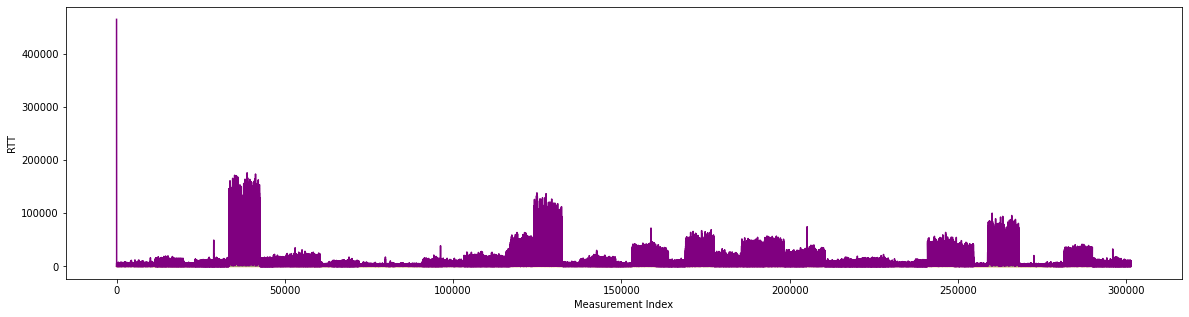

In [12]:
ewma = pd.Series.ewm
plt.figure(figsize=(20, 5))
# x = np.linspace(0, 2 * np.pi, 100)
# y = 2 * np.sin(x) + 0.1 * np.random.normal(x)

# master = raw
master = synth

# y = master['rtt'].reset_index(drop=True)
# y = master['rtt'][:25000].reset_index(drop=True)
y = master['rtt'] # entire dataset

df = pd.Series(y)
# take EWMA in both directions then average them

SPAN = 20

fwd = ewma(df, span=SPAN / 2).mean() # take EWMA in fwd direction
bwd = ewma(df[::-1], span=SPAN).mean() # take EWMA in bwd direction

# print(f"fwd, bwd: {fwd}, {bwd}")

filtered = np.vstack(( fwd, bwd[::-1] )) # lump fwd and bwd together
filtered = np.mean(filtered, axis=0 ) # average

plt.plot(y, color = 'orange', alpha=.33) # raw data
plt.plot(filtered, color='green', alpha=0.33) # combined ewma's
plt.plot(fwd, color='red', alpha=0.1) # forward ewma
plt.plot(bwd, color='blue', alpha=0.1) # bwd ewma

diff = np.array(fwd) - np.array(bwd) # 
dist = np.square(diff)
# print(np.round(dist, 2))
plt.plot(dist, color='purple', alpha=1)

# plt.ylim(top=250, bottom=-10)

plt.xlabel('Measurement Index')
plt.ylabel('RTT')
plt.show()

In [ ]:
# save dist in dataset for current use
def new_changept(ewma_dist, client_id):
    global medians
    THRESHOLD = medians[client_id]
    if ewma_dist > THRESHOLD:
        return VOTE
    else:
        return NORMAL
    
# ripe['ewma_dist'] = np.round(dist, 2)
# ripe['changepoint'] = ripe.apply(lambda x: new_changept(x.ewma_dist), axis=1)
tmp = ripe[:25000 * 5]

# raw['ewma_dist'] = np.round(dist, 2)
# tmp = raw[:5000]

# tmp['changepoint'] = tmp.apply(lambda x: new_changept(x.ewma_dist, int(x.id)), axis=1)

In [ ]:
# ripe[ripe['id'] == 0].head(20)

# tmp['ewma_dist']

medians = []
for i in range(10):
#     medians.append(int(tmp[tmp['id'] == i]['ewma_dist'].median().round()))
#     medians.append(int(tmp[tmp['id'] == i]['ewma_dist'].quantile(0.33).round())) # too many positive results
#     medians.append(int(tmp[tmp['id'] == i]['ewma_dist'].quantile(0.45).round())) # all positives
#     medians.append(int(tmp[tmp['id'] == i]['ewma_dist'].quantile(0.55).round())) # all false
    medians.append(int(tmp[tmp['id'] == i]['ewma_dist'].quantile(0.49).round())) 
medians

### Here, we develop two network queries using logical operations between previously implemented tasks. 
We conduct these queries using combined labeling functions, which conduct lookups on the preexisting labels and label their values accordingly.

In [ ]:
def query1(x):
    return (x.noise or x.changepoint or x.loss)

def query2(x):
    return (x.noise or x.changepoint or x.congestion)

""" Apply Query 1 Labeling function. """
synth['query1'] = synth.apply(lambda x: query1(x), axis=1)
synth['query2'] = synth.apply(lambda x: query2(x), axis=1)

# raw['query1'] = raw.apply(lambda x: query1(x), axis=1)
# raw['query2'] = raw.apply(lambda x: query2(x), axis=1)

#### Now, develop test/training sets

In [13]:
""" First, define global tasks to create dataloaders for. """
# tasks = ["loss", "congestion", "noise"]
tasks = ["loss", "congestion", "noise", "changepoint"]
# tasks = ["loss", "congestion", "noise", "changepoint", "query1", "query2"]

# X values are the measurements (rtt), Y values are the associated labels
X_train, X_validate, X_test = {}, {}, {}
Y_train, Y_validate, Y_test = {}, {}, {}

""" Uncomment to use the CAIDA Data """
dataframe = synth  # synthetic CAIDA data
test_set = raw
num_entries = 28 # 28 entries in CAIDA Ark Dataset

# dataframe = tmp
# test_set = tmp
num_entries = 3

In [14]:
dataframe

,id,i,rtt,loss,congestion,noise
0,0,0,29.445,0,0,0
1,0,0,0.000,1,0,0
2,0,0,36.000,0,1,0
3,0,0,724.000,0,0,1
4,0,1,29.688,0,0,0
5,0,1,0.000,1,0,0
6,0,1,42.000,0,1,0
7,0,1,559.000,0,0,1
8,0,2,32.005,0,1,0
9,0,2,0.000,1,0,0


In [15]:
# Only use augmented data for training; use raw data for testing
for i in range(num_entries):
    global dataframe
    master = get(dataframe, index=i)
    test = get(test_set, index=i)
    
    for task in tasks:
        splt = split_df(master)
#         print(splt)
#         splt_2 = split_df(test_set, ct=4)
        splt_2 = split_df(dataframe, ct=4)
        splt_2 = splt_2[1].append(splt_2[2], ignore_index=True)

        X_train[task] = splt[0]['rtt'].apply(lambda x : np.array([x]))
        X_validate[task] = splt[1]['rtt'].apply(lambda x : np.array([x]))
#         print((splt_2.head()))
        X_test[task] = splt_2['rtt'].apply(lambda x : np.array([x]))

        Y_train[task] = splt[0][task]
        Y_validate[task] = splt[1][task]
        Y_test[task] = splt_2[task]

rtts = master['rtt'].apply(lambda x : np.array([x])) # convert rtt's into np array of sample arrays

KeyError: 'changepoint'

In [16]:
X_train_tensors = X_train['changepoint']

# print(X_train['changepoint'], type(X_train['changepoint']))

# torch_tensor = torch.tensor(X_train['changepoint'])
# print(torch_tensor)

# head = ripe[ripe['id'] == 0].round(decimals=2)
# print(head)
# tensor = (torch.tensor(ripe[ripe['id'] == 0].values)).long()
# print(tensor.shape)



# print(X_train_tensors.shape)

# X_train_tensors_final = torch.reshape(
#                             X_train_tensors, 
#                             (
#                                 X_train_tensors.shape[0], 
#                                 1, 
#                                 X_train_tensors.shape[1]
#                             )
#                         )

________________

In [17]:
from snorkel.classification import DictDataset, DictDataLoader, Operation, Task, MultitaskClassifier, Trainer
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
from snorkel.analysis import Scorer
from timeit import default_timer as timer

METRICS = ["f1"]
LOSS_FUNC = F.cross_entropy
# LOSS_FUNC = F.binary_cross_entropy
SCORES = {}

def train_and_evaluate(df, i : int, tasks : list, show_conf_matrix=False, n_epochs=10, lr=0.01, directory="", savefig=False, \
                       cache_model=True, titleprefix="", show_progress=False, model_name="MTL_Latest", \
                       use_cached=False, time_override=False):
    """ Iteratively train and evaluate the ith synthesized dataset. Results are stored in the SCORES dictionary, rather 
        than being returned. """
    global SCORES, METRICS, LOSS_FUNC, SEED
    CACHE_DIR = "./cache/"
    
    X_train, X_validate, X_test = {}, {}, {}
    Y_train, Y_validate, Y_test = {}, {}, {}
    
    master = get(df, index=i)
    for task in tasks:
        splt = split_df(master)
        splt_2 = split_df(master, ct=4)
        splt_2 = splt_2[1].append(splt_2[2], ignore_index=True)

        X_train[task] = splt[0]['rtt'].apply(lambda x : np.array([x]))
        X_validate[task] = splt[1]['rtt'].apply(lambda x : np.array([x]))
        X_test[task] = splt_2['rtt'].apply(lambda x : np.array([x]))

        Y_train[task] = splt[0][task]
        Y_validate[task] = splt[1][task]
        Y_test[task] = splt_2[task]

        # new_df = pd.DataFrame()
        # new_df['rtt'] = splt[0]['rtt'] # first tensor value is RTT
        # new_df['datetime'] = splt[0]['datetime'] # second is datetime
        # new_df['seq_len'] = 32
        # # new_df[task] = splt[0][task] # assign 3rd tensor value to ground truth label
        
        # tensor = torch.LongTensor(new_df.values)
        # print(tensor)
        # X_train[task] = tensor
        
        # new_df = pd.DataFrame()
        # new_df['rtt'] = splt[1]['rtt'] # first tensor value is RTT
        # new_df['datetime'] = splt[1]['datetime'] # second is datetime
        # X_validate[task] = torch.LongTensor(new_df.values)
        
        # new_df = pd.DataFrame()
        # new_df['rtt'] = splt_2['rtt'] # first tensor value is RTT
        # new_df['datetime'] = splt_2['datetime'] # second is datetime
        # X_test[task] = torch.LongTensor(new_df.values)

        Y_train[task] = splt[0][task]
        Y_validate[task] = splt[1][task]
        Y_test[task] = splt_2[task]
        
        
    rtts = master['rtt'].apply(lambda x : np.array([x])) # convert rtt's into np array of sample arrays


    """ Now, we define the dataloaders for the model. These will access the input data dictionaries for each
        individual dataset and load the required portions needed for validation, training, and testing evaluations. """
    
    loaders = {t : [] for t in ["train", "valid", "test"] + tasks} # used for confusion matrix generation
    dataloaders = []
    
    for task_name in tasks:
        for split, X, Y in (
                ("train", X_train, Y_train),
                ("valid", X_validate, Y_validate),
                ("test", X_test, Y_test),
            ):
            
            X_dict = {f"{task_name}_data": torch.FloatTensor(X[task_name])}
            # X_dict = {f"{task_name}_data": torch.LongTensor(X[task_name])}
            # print(X_dict)
    
            Y_dict = {f"{task_name}_task": torch.LongTensor(Y[task_name])}
            
            dataset = DictDataset(f"{task_name}_Dataset", split, X_dict, Y_dict)
            dataloader = DictDataLoader(dataset, batch_size=32) # batch size is the number of data points loaded in at time
            dataloaders.append(dataloader)

            loaders[split].append(dataloader)     # add current loader to list sorted by data type (test, train, or val)
            loaders[task_name].append(dataloader) # add current loader based on task
    
    
    """ Here, we define the initial layers of the perceptron model. 'base_mlp' indicates the layer shared between the 
        different tasks, while the 'head_module' denotes the model's prediction layer. """

    # Define a two-layer MLP module and a one-layer prediction "head" module
    # base_mlp = nn.Sequential(nn.Linear(2, 8), nn.ReLU(), nn.Linear(8, 4), nn.ReLU())
    
    numLayers = 4 # default 4
    hiddenSize = 4 # default 4
    in_features = 1
    
    base_mlp = nn.Sequential(
                    # nn.LSTM(in_features, hidden_size=hiddenSize, num_layers=1, bidirectional=True),
                    # nn.ReLU(),
                    nn.Linear(in_features, hiddenSize), 
                    nn.ReLU(),
                    nn.Linear(hiddenSize, 4), 
                    nn.ReLU()
                )
    
    # head_module = nn.Linear(4, 2)
    # # The module pool contains all the modules this task uses
    # module_pool = nn.ModuleDict({"base_mlp": base_mlp, "loss_head_module": head_module})

    # # From the input dictionary, pull out 'loss_data' and send it through input_module
    # op1 = Operation( name="base_mlp", module_name="base_mlp", inputs=[("_input_", "loss_data")] )
    # # Pass the output of op1 (the MLP module) as input to the head_module
    # op2 = Operation( name="loss_head", module_name="loss_head_module", inputs=["base_mlp"] )
    # op_sequence = [op1, op2]
    
    
    def initialize_task(taskname : str, base):
        """ A more modular method of defining the same tasks as seen above. """
        global LOSS_FUNC, METRICS
        
        in_features = 4  # number of elements in hidden layer
        out_features = 2
        
        task = Task(
            name = f"{taskname}_task",
            module_pool = nn.ModuleDict({"base_mlp": base, f"{taskname}_head": nn.Linear(in_features, out_features)}),
            loss_func = LOSS_FUNC,
            output_func = partial(F.softmax, dim=1),
            scorer = Scorer(metrics=METRICS),
            op_sequence = [
                    Operation("base_mlp", [("_input_", f"{taskname}_data")]), # base multi-layered perception
                    Operation(f"{taskname}_head", ["base_mlp"]),
                ]
            )
        
        return task
    
#     loss_task = initialize_task("loss", base_mlp)
#     noise_task = initialize_task("noise", base_mlp)
#     congestion_task = initialize_task("congestion", base_mlp)
#     changepoint_task = initialize_task("changepoint", base_mlp)
#     ddos_task = initialize_task("ddos", base_mlp)
    
    TASKS = [initialize_task(t, base_mlp) for t in tasks]
        
    # TASKS = [loss_task, noise_task, congestion_task] # original tasks
    # TASKS = [loss_task, noise_task, congestion_task, changepoint_task]
    # TASKS = [loss_task, noise_task, congestion_task, changepoint_task, ddos_task]
    
    """ Finally, we train the Multi Task classifier and score it according to our evaluation metrics list described above. 
        By default, we use the model's F1 score as the basis for evaluation. The duration of the training process for each 
        individual dataset within the model is also recorded. """
    
    # model = MultitaskClassifier(TASKS)
    model = MultitaskClassifier(TASKS, device=CUDA_INDEX) # use GPU device if available
    
    if torch.cuda.is_available() and CUDA_INDEX >= 0:
        model.to(f'cuda:{CUDA_INDEX}') # load to GPU if available
    
    trainer_config = { # see https://github.com/snorkel-team/snorkel/blob/master/snorkel/classification/training/trainer.py
        "seed": SEED,
        "n_epochs": n_epochs, 
        "lr": lr,
        "lr_scheduler": "linear", # one of ["constant", "linear", "exponential", "step"]
        "progress_bar": show_progress,
        "checkpointing": True
    }
    trainer = Trainer(**trainer_config)
    
    if use_cached:
        try:
            model.load(CACHE_DIR + model_name)
        except:
            use_cached = False # if we fail to load config, simply regen model config
            print(f"Error loading cached model {model_name}")
    
    
    start = timer() # get current time for measurement analysis    
    trainer.fit(model, dataloaders)
    end = timer()

    model.eval()
    
    results = model.score(dataloaders, as_dataframe=False)
    # print(model.eval())
    # print('model.score:', results)
    
    try:
        if time_override:
            assert False
        if "Time" in SCORES[i].keys(): # if this is a second iteration:
            SCORES[i]["Time"] = round(SCORES[i]["Time"] + round(end - start, 5), 5)
            SCORES[i]["Scores"] = results
            SCORES[i]["Iterations"] += 1
    except:
        SCORES[i] = {"Time": round(end - start, 5), "Scores": results, "Index": i, "Iterations": 0}
        

    """  Cache MTL Model to specified filepath: """
    
    if cache_model:
        model.save(CACHE_DIR + model_name)
    
        
    """ Generating Confusion Matrices: """    

    typ = "test" # test, train, or valid; which set of the data should be used to generate the confusion matrices?
    result_list = []
    
    for dl in loaders[typ]:
        res = model.predict(dl, return_preds=True)
        result_list.append(res)

        # print('model.predict:', res)
        # print(res['preds'].keys())
        
        key = list(res['preds'].keys())[0]

        preds = res["preds"][f"{key}"] # predictions
        
        try:
            if show_conf_matrix:
                weak_labels = dl.dataset.Y_dict[f"{key}"].numpy() # convert tensor to np array
                conf = gen_confusion_matrix(preds, weak_labels, index=f"{i:02d}", filetype="png", save=savefig, \
                                     selected_feature=key.split('_')[0], pre=titleprefix, useTitle=True, folder=directory)
        except:
            print(f"Error drawing confusion matrix for {i:02d}: {key}")
            pass
    
    """ Printing hidden model layers. """
    # l = [module for module in model.modules() if not isinstance(module, nn.Sequential)]
    # print(l)

    # print(list(model.modules()))
    
    # print("=" * 50)
    # print(f"model: {model}")
    # print(dir(model))
    # print(model.modules)
    # print(model.add_module)
    # print(model.add_task)
    
    return result_list

### Now that all the helper functions are defined, it's time to train the model.  
We do this by calling the `train_and_evaluate()` function defined above. The `sets` parameter is a `list`-like object containing the indices of the datasets to train and evaluate the model on. To train on all 28 datasets, `sets` should contain indices `0..27`.

In [18]:
SCORES = {}

# CAIDA Presets
# sets = range(28)    # train on all 28 datasets
# sets = [11, 15, 26] # train only on a specific subset of the datasets
sets = range(1)

# results = {}

rates = [0.01] # learning rates to try
rates = [0.0001] # naive learning rates
avgs = []

# tasks = ["loss", "noise", "congestion", "changepoint", "query1", "query2"]
# tasks = ["loss", "noise", "congestion", "changepoint"]
tasks = ["loss", "noise", "congestion"]
# tasks = ["changepoint"]

# tasks = ["noise", "changepoint", "loss", "query1"]
# tasks = ["noise", "changepoint", "query1", "query2"]

for rate in rates:
#     SCORES = {}
    for i in sets:
        print(f"{'='*5} Training on dataset {i:02d} {'='*5}")

        EPOCHS = 5
    
        cache = True # use cached model
        cache = False
        save_cache = False
    
        # CAIDA -- train on augmented, test on original/raw
        results = train_and_evaluate(synth, i, tasks, savefig=False, show_conf_matrix=False, \
                                     n_epochs=EPOCHS, lr=rate, titleprefix="lr_", cache_model=save_cache, \
                                     show_progress=True, use_cached=cache, model_name=f"{i:02d}_MTL")
                        
        # Raw CAIDA data
        # results = train_and_evaluate(raw, i, tasks, savefig=False, show_conf_matrix=False, \
        #                              n_epochs=EPOCHS, lr=rate, titleprefix="raw_", cache_model=save_cache, \
        #                              show_progress=True, use_cached=cache, model_name=f"{i:02d}_MTL_raw")

    avg = 0
    time = 0
    pprint(SCORES)
    
    for i in SCORES:
        for j in SCORES[i]['Scores']:
            avg += SCORES[i]['Scores'][j] / len(SCORES[i]['Scores'])

        time += SCORES[i]["Time"]

    avg /= len(SCORES)
    avgs.append(avg)
    print(f"\nMean F1 score: `{avg}`  ")
    print(f'Total time: `{round(time, 5)}` seconds.\n')
    
print("Done.")


===== Training on dataset 00 =====


Epoch 4:: 100%|██████████| 507/507 [00:02<00:00, 174.64it/s, model/all/train/loss=0.372, model/all/train/lr=0, loss_task/loss_Dataset/valid/f1=1, noise_task/noise_Dataset/valid/f1=0.994, congestion_task/congestion_Dataset/valid/f1=0]      


{0: {'Index': 0,
     'Iterations': 0,
     'Scores': {'congestion_task/congestion_Dataset/test/f1': 0.0,
                'congestion_task/congestion_Dataset/train/f1': 0.0,
                'congestion_task/congestion_Dataset/valid/f1': 0.0,
                'loss_task/loss_Dataset/test/f1': 1.0,
                'loss_task/loss_Dataset/train/f1': 1.0,
                'loss_task/loss_Dataset/valid/f1': 1.0,
                'noise_task/noise_Dataset/test/f1': 0.9917127071823205,
                'noise_task/noise_Dataset/train/f1': 0.9916394038531443,
                'noise_task/noise_Dataset/valid/f1': 0.994417306350314},
     'Time': 15.25767}}

Mean F1 score: `0.6641966019317531`  
Total time: `15.25767` seconds.

Done.


In [1]:
""" Printing the initial scores: """
time = 0

avg = 0 # average F1 score
p = True # True to print result dictionary

for i in SCORES:
    if p: # if should print
        print('```  ')
        pprint(SCORES[i])
        print('```  ')
    
    for j in SCORES[i]['Scores']:
        avg += SCORES[i]['Scores'][j] / len(SCORES[i]['Scores'])
        
    time += SCORES[i]["Time"]

avg /= len(SCORES)
learningrate = "Flexible, started at 0.01"
print(f"\nMean F1 score: `{avg}`  ")
print(f"Mean Time score: `{round(time / len(SCORES), 5)}` seconds  ")
print(f'Total time: `{round(time, 5)}` seconds.')

NameError: name 'SCORES' is not defined

___________  
### Results:

In [95]:
""" Serialize results: """
prev_names = ["min_0.90", "min_0.92", "synth_4x_raw", "synth_4x_reiterated_10x", "synth_4x_reiterated_7x", "gap500", \
              "gap500_noreiterate", "latest", "gap500_1x", "lr0015_initial", "lr0015_min95"]

# save(SCORES, "lr_adaptive")
# save(SCORES, "lr_adaptive_cont")
# save(SCORES, "CAIDA_max")

# save(SCORES, "CAIDA_scores")
# save(SCORES, "CAIDA_retrain")
# save(SCORES, "CAIDA_queries")

""" Load serialized results from root/MTL/data/ """
# saved_scores = load("CAIDA_max")
# saved_scores = load("CAIDA_scores")
# saved_scores = load("CAIDA_retrain")
# saved_scores = load("CAIDA_queries")

In [ ]:
### Combining result dicts:
# old = load("CAIDA_retrain")
# for i in SCORES:
#     old[i] = SCORES[i]
# save(old, "CAIDA_retrain")

### If needed, we can re-train the models iteratively using a given number of retry attempts.

In [28]:
# SCORES = saved_scores

def redo_list(redoThreshold):
    global SCORES
    redos = []
    for j in SCORES.keys():
        for s in SCORES[j]['Scores'].keys():
            if "test" not in s:
                continue # only care about test datasets

            if SCORES[j]['Scores'][s] < redoThreshold:
                if "changepoint" in s:
                    changeThresh = 0.65
                    if SCORES[j]['Scores'][s] < changeThresh:
                        redos.append(j)
                        print(f"Dataset {j:02d} -- {s} == {SCORES[j]['Scores'][s]} < {changeThresh}")
                else:
                    redos.append(j)
                    print(f"Dataset {j:02d} -- {s} == {SCORES[j]['Scores'][s]} < {redoThreshold}")
                break
    return redos

redos = redo_list(0.50)

print(f"redos: {redos}")

Dataset 00 -- congestion_task/congestion_Dataset/test/f1 == 0.0 < 0.5
Dataset 02 -- congestion_task/congestion_Dataset/test/f1 == 0.0 < 0.5
redos: [0, 2]


In [33]:
# SCORES = load('synth_4x_reiterated_7x')
# SCORES = load('latest')
# SCORES = load("lr_adaptive")

attempts = 5 # number of times to try again if model scores are less than desired.
redoThreshold = 0.90 # any score less than this indicates the model needs to be re-trained

# df = master
df = synth
# df = ripe


EPOCHS = 10

RATE = 0.01

for i in range(attempts):
    print('-'*4, f"Iteration {i + 1}", '-'*4)
    
    redos = redo_list(redoThreshold)
    
    for j in redos:
        print(f"{'='*5} Re-Training on dataset {j:02d} {'='*5}")

        if (df.equals(synth)): # Synthetic
            results = train_and_evaluate(df, j, tasks, savefig=False, show_conf_matrix=False, cache_model=True, \
                                         n_epochs=EPOCHS, lr=rate, titleprefix="caida_", time_override=True, \
                                         show_progress=True, use_cached=False, model_name=f"CAIDA_{i:02d}")
        # RIPE Atlas
        elif (df.equals(ripe)):
            results = train_and_evaluate(df, j, tasks, savefig=False, show_conf_matrix=True, time_override=True, \
                                         n_epochs=EPOCHS, lr=rate, titleprefix="ripe_", cache_model=True, \
                                         show_progress=True, use_cached=False, model_name=f"RIPE_{i:02d}_MTL", \
                                         directory="ripe")
    
    if redos == []:
        print(f"Model satisfactorily trained after {i + 1} iterations.")
        break
    else:
        print("Models that need to be re-trained:\n", redo_list(redoThreshold))
    
    if i == attempts - 1:
        print("Iteration attempts exceeded.")
    print()

---- Iteration 1 ----
Dataset 00 -- congestion_task/congestion_Dataset/test/f1 == 0.0 < 0.9
Dataset 02 -- congestion_task/congestion_Dataset/test/f1 == 0.0 < 0.9
===== Re-Training on dataset 00 =====


My Device: 0	 Config Device: 0




Epoch 9:: 100%|██████████| 676/676 [00:16<00:00, 41.13it/s, model/all/train/loss=0.0945, model/all/train/lr=0, loss_task/loss_Dataset/valid/f1=1, noise_task/noise_Dataset/valid/f1=0.997, congestion_task/congestion_Dataset/valid/f1=0.759, changepoint_task/changepoint_Dataset/valid/f1=0.989]      


===== Re-Training on dataset 02 =====


My Device: 0	 Config Device: 0




Epoch 9:: 100%|██████████| 636/636 [00:15<00:00, 41.81it/s, model/all/train/loss=0.0922, model/all/train/lr=0, loss_task/loss_Dataset/valid/f1=1, noise_task/noise_Dataset/valid/f1=0.995, congestion_task/congestion_Dataset/valid/f1=0.757, changepoint_task/changepoint_Dataset/valid/f1=0.991]       


Dataset 00 -- congestion_task/congestion_Dataset/test/f1 == 0.7661194384963121 < 0.9
Dataset 02 -- congestion_task/congestion_Dataset/test/f1 == 0.7525851197982346 < 0.9
Models that need to be re-trained:
 [0, 2]

---- Iteration 2 ----
Dataset 00 -- congestion_task/congestion_Dataset/test/f1 == 0.7661194384963121 < 0.9
Dataset 02 -- congestion_task/congestion_Dataset/test/f1 == 0.7525851197982346 < 0.9
===== Re-Training on dataset 00 =====


My Device: 0	 Config Device: 0




Epoch 9:: 100%|██████████| 676/676 [00:16<00:00, 41.43it/s, model/all/train/loss=0.0234, model/all/train/lr=0, loss_task/loss_Dataset/valid/f1=1, noise_task/noise_Dataset/valid/f1=0.999, congestion_task/congestion_Dataset/valid/f1=0.985, changepoint_task/changepoint_Dataset/valid/f1=0.989]      


===== Re-Training on dataset 02 =====


My Device: 0	 Config Device: 0




Epoch 9:: 100%|██████████| 636/636 [00:15<00:00, 40.98it/s, model/all/train/loss=0.0234, model/all/train/lr=0, loss_task/loss_Dataset/valid/f1=1, noise_task/noise_Dataset/valid/f1=0.994, congestion_task/congestion_Dataset/valid/f1=0.963, changepoint_task/changepoint_Dataset/valid/f1=0.991]       


Models that need to be re-trained:
 []

---- Iteration 3 ----
Model satisfactorily trained after 3 iterations.


### Lastly, we analyze and print the average scores and training times for the models.

In [132]:
# save(SCORES, "ripe")
# save(SCORES, "ripe_changepoint")
# save(SCORES, "ripe_all")

# save(SCORES, "CAIDA_max")
# save(SCORES, "CAIDA_scores")
# save(SCORES, "CAIDA_retrain")
# save(SCORES, "CAIDA_queries")

In [34]:
from statistics import mean, stdev

congestion_scores = []
loss_scores       = []
noise_scores      = []
times             = []

saved_scores = SCORES
# del saved_scores[11]
# print(saved_scores[11])
# saved_scores = load("synth_4x_reiterated_7x")

min_score = 1.0
for k in list(saved_scores[list(saved_scores.keys())[0]]['Scores'].keys()):
    # For each key in the 'Scores' dict...
    if "test" not in k:
        continue # only use 'test' scores
    
    current = [saved_scores[j]['Scores'][k] for j in saved_scores.keys()]
    
    c_min = min([c for c in current if c != 0]) # ignore 0.0s when mentioning min score
#     c_min = min(current)
    
    min_score = min(c_min, min_score)
    
    print(f"mean test score for {k.split('_')[0]} \t: `{round(mean(current), 6)}`  ")

for j in saved_scores.keys():
    times.append(saved_scores[j]["Time"])
print(f"\nMean time to train to F1 score ≥ {round(min_score, 3)}:   `{round(mean(times), 5)}` seconds, stdev: `{round(stdev(times), 5)}`s  ")
print(f'Total time: `{round(sum(times), 5)}` seconds.  ')

mean test score for loss 	: `1.0`  
mean test score for noise 	: `0.995567`  
mean test score for congestion 	: `0.97134`  
mean test score for changepoint 	: `0.990527`  

Mean time to train to F1 score ≥ 0.96:   `164.05881` seconds, stdev: `16.31631`s  
Total time: `492.17642` seconds.  


### And if desired, we can print the entire raw SCORES dictionary for visual confirmation.

In [ ]:
for i in SCORES:
    print('```  ')
    pprint(SCORES[i])
    print('```  ')